## Testing affinity loop with multiple reaction steps

Data.

In [1]:
%reload_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

import torch
import pyarrow.parquet as pq
table = pq.read_table('../../dgym-data/sizes.parquet')[0]
sizes = torch.tensor(table.to_numpy())

Docking.

In [196]:
import os

dockstring_dir = f'{path}/dockstring_targets/'
files = os.listdir(dockstring_dir)
configs = sorted([f for f in files if 'conf' in f])
targets = sorted([f for f in files if 'target' in f])

idx = 11
with open(dockstring_dir + configs[idx], 'r') as f:
    config_ = f.readlines()
    config_ = [c.replace('\n', '') for c in config_]
    config_ = [c.split(' = ') for c in config_ if c]
    config_ = {c[0]: float(c[1]) for c in config_}

target = targets[idx]
name = target.split('_')[0]

config_.update({
    'size_x': 22.5,
    'size_y': 22.5,
    'size_z': 22.5,
})

from dgym.envs.oracle import DockingOracle, NeuralOracle, NoisyOracle
from dgym.envs.utility import ClassicUtilityFunction

config = {
    'search_mode': 'detailed',
    'scoring': 'gnina',
    'seed': 5,
    **config_
}

# Create noiseless evaluators
docking_oracle = DockingOracle(
    f'{name} affinity',
    receptor_path=f'{dockstring_dir}/{target}',
    config=config
)

Designer.

In [3]:
from dgym.molecule import Molecule
from dgym.envs.designer import Designer, Generator
from dgym.envs.drug_env import DrugEnv
from dgym.agents import SequentialDrugAgent
from dgym.agents.exploration import EpsilonGreedy
from dgym.experiment import Experiment

designer = Designer(
    Generator(building_blocks, fingerprints, sizes),
    reactions,
    cache = True
)

In [186]:
mols = [
    m for i in range(4)
    for m in designer.design(deck[i], 1_000)
]

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 12.44444444444443, 'Molecular weight')

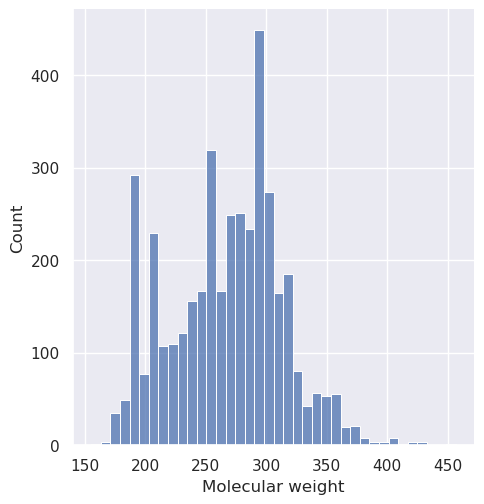

In [187]:
from rdkit.Chem.Descriptors import ExactMolWt

sns.displot([ExactMolWt(m.mol) for m in mols])
plt.xlabel('Molecular weight')

Pick 5 random starting hits.

In [25]:
# select first molecule
import random
def select_molecule(deck):
    initial_index = random.randint(0, len(deck) - 1)
    initial_molecule = deck[initial_index]
    if len(initial_molecule.reactants) == 2 \
        and designer.match_reactions(initial_molecule):
        return initial_molecule
    else:
        return select_molecule(deck)

initial_molecules = [select_molecule(deck) for _ in range(5)]
initial_library = dg.MoleculeCollection(initial_molecules)
initial_library.update_annotations()
library = initial_library

In [64]:
import numpy as np

scores = docking_oracle(library)
best = np.nanargmax(scores).item()
print(np.nanmax(scores))
print(best)

for step in range(5):
    
    if step == 3:
        library += designer.design(library[best], 20, mode='grow')
    else:
        library += designer.design(library[best], 20, mode='replace')

    scores = docking_oracle(library)
    best = np.nanargmax(scores).item()
    
    print(step, np.nanmax(scores))
    print(step, best)

7.360362820031432
99
0 7.662002751121438
0 189
1 7.662002751121438
1 189
2 7.662002751121438
2 189
3 7.662002751121438
3 189
4 7.662002751121438
4 189


Text(0.5, 0, 'Heavy atom count')

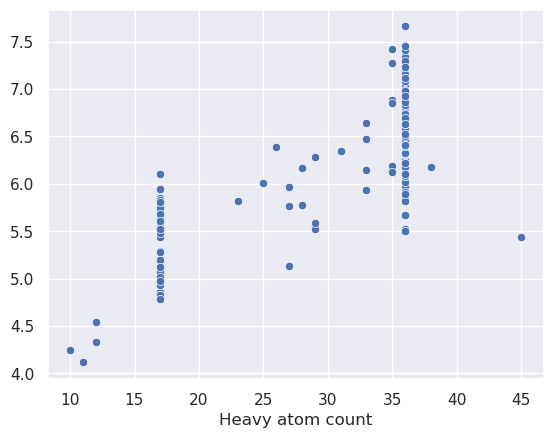

In [193]:
from rdkit.Chem.Descriptors import HeavyAtomCount

sns.scatterplot(x=[HeavyAtomCount(m.mol) for m in library], y=docking_oracle(library))
plt.xlabel('Heavy atom count')
# plt.ylabel

In [65]:
records = []
for idx, (mol, score) in enumerate(zip(library, scores)):
    records.append({'score': score, 'timestep': 1 + ((idx - 5) // 20)})
    
import pandas as pd
df = pd.DataFrame(records)

In [143]:
from tqdm.notebook import tqdm

medians = []
for num_replicates in tqdm([1, 2, 4, 8, 16, 32, 64]):
    median = np.median(docking_oracle([library[189]] * num_replicates, use_cache=False))
    medians.append(median)

  0%|          | 0/7 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Docking of a single molecule across replicates')

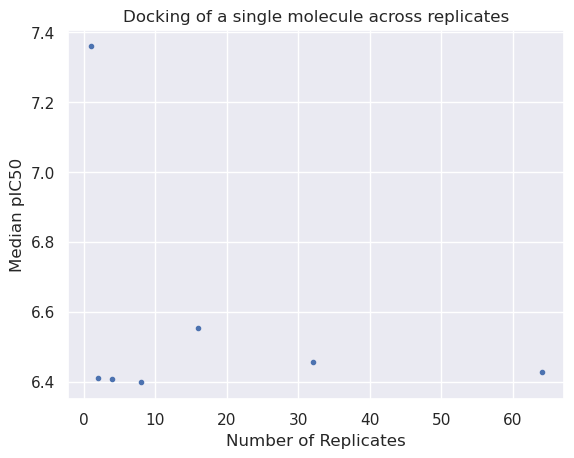

In [162]:
plt.plot([1, 2, 4, 8, 16, 32, 64], medians, '.')
plt.xlabel('Number of Replicates')
plt.ylabel('Median pIC50')
plt.title('Docking of a single molecule across replicates')

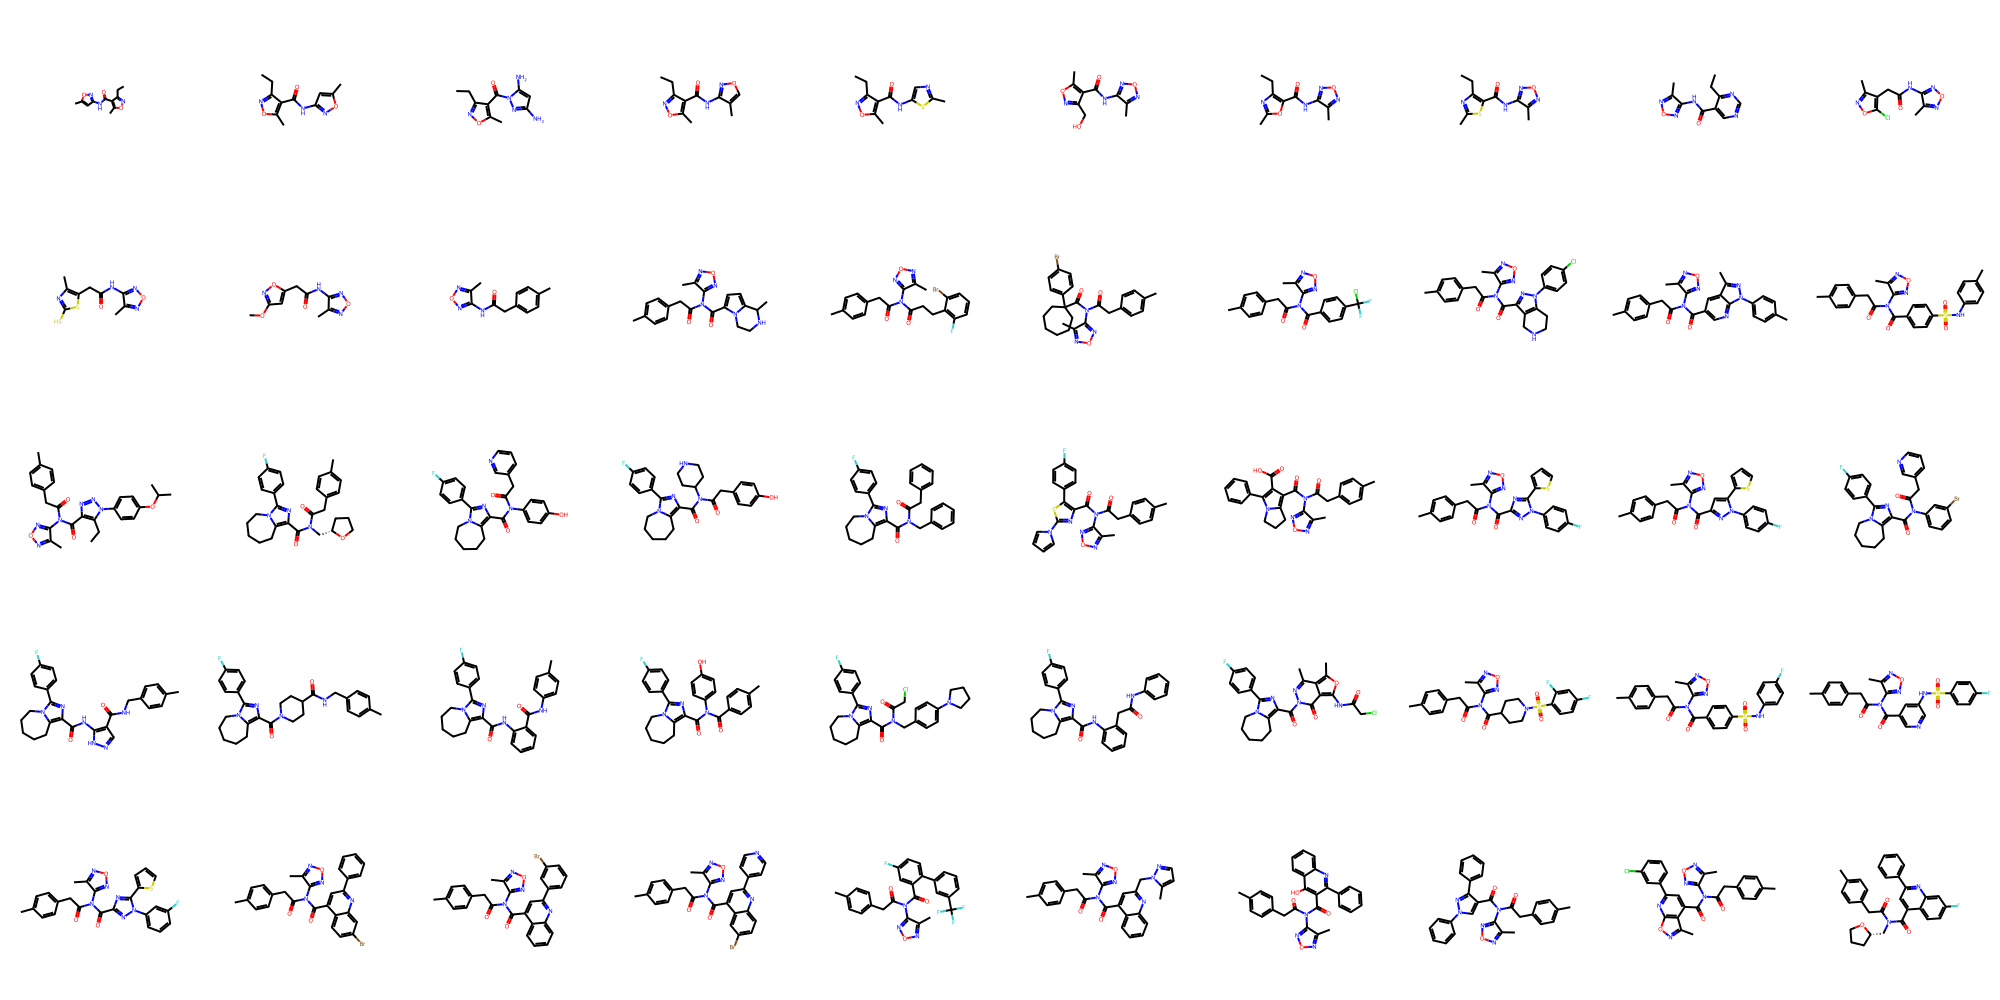

In [93]:
from rdkit.Chem.Draw import MolsToGridImage

MolsToGridImage([m.mol for m in library[::5]], molsPerRow=10)

/tmp/ipykernel_357925/2326954617.py:6: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(


Text(0.5, 1.0, 'Distribution of Docking Scores Across Rounds')

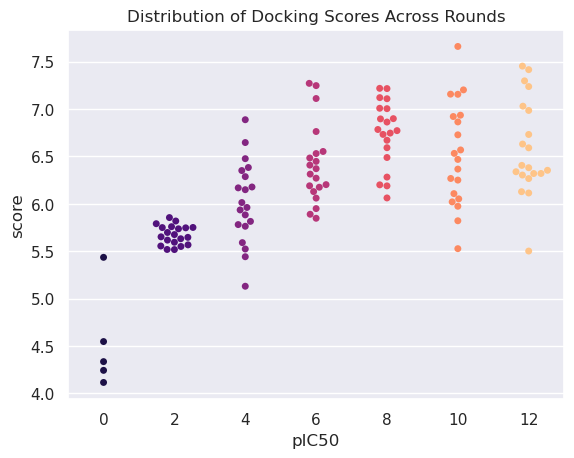

In [195]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

sns.swarmplot(
    df.query('timestep % 2 == 0'),
    y='score',
    x='timestep',
    palette='magma',
    # complementary=True
)

plt.xlabel('pIC50')
plt.title('Distribution of Docking Scores Across Rounds')

In [12]:
# drug_env = DrugEnv(
#     designer,
#     library = initial_library,
#     assays = assays,
#     budget = 500,
#     utility_function = composite_utility,
# )